## Fire incidents Amsterdam 2012-2015 

http://data.amsterdam.nl/dataset/brandmeldingen-2010-2015

Overview of all incidents of the Amsterdam-Amstelland fire brigade in the period 2010 untill 2015 (partly). More than 125.000 incidents contain type of incidents, district & neighborhood , date/time and priority.

We will merge these incidents with a shapefile from the CBS (Centraal Bureau Statistiek) to attach lots of additional datapoints with stats from each district of Amsterdam and plot incidents on a map. 

Bronvermelding
© Kadaster / Centraal Bureau voor de Statistiek, 2016

In [1]:
# load in modules
%matplotlib inline
import os; import csv
import pandas as pd ; import numpy as np
import matplotlib.pyplot as plt; import seaborn as sns
from collections import defaultdict, Counter
import shapefile # pip install pyshp in case not installed

In [2]:
# settings matplotlib and paths
pd.set_option('display.max_columns', 100)
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 10.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [15., 6.]

# path and file
path = 'C:\\Users\\Schiphol\\Documents\\data\\'
file = 'brwaa_2010-2015.csv'

In [3]:
# clean and read-in function
def read_file(file, sep):
    df = (pd.read_csv(file, sep = ';')
          .pipe(strip_cols)
          .assign(datum = lambda x: pd.to_datetime(x['datum'], format= '%Y-%m-%d'),
                  start_tijd = lambda x: pd.to_datetime(x['start_tijd'], format= '%Y-%m-%d %H:%M:%S'),
                  index = lambda x:  1)
          .rename(columns={'landelijke_meldingsclassificatie_niveau1': 'melding_1',
                           'landelijke_meldingsclassificatie_niveau2': 'melding_2',
                           'landelijke_meldingsclassificatie_niveau3': 'melding_3'})
         )
    return df
        
def strip_cols(df):
    cols_to_clean = ['incident_type', 'maand_naam', 'dag_naam', 'dagdeel', 'landelijke_meldingsclassificatie_niveau3',
                    'landelijke_meldingsclassificatie_niveau2','landelijke_meldingsclassificatie_niveau1','objecttype', 
                     'objectfunctie', 'buurt', 'wijk', 'woonplaats', 'gemeente']
    df.loc[: , (cols_to_clean)] = df.loc[: , (cols_to_clean)].apply(lambda x: x.str.strip().replace('', np.nan).fillna('Onbekend'))
    df = df.copy()
    return df

In [4]:
# read in data and store in df
df = read_file(path + file, sep = ';')
df['jaar'] = df['datum'].dt.year

In [5]:
df.head(2)

,incident_id,start_tijd,incident_type,melding_1,melding_2,melding_3,datum,jaar,maand_nr,maand_naam,dag_nr,dag_naam,week_nr,kwartaal,prioriteit,uur,dagdeel,objecttype,objectfunctie,buurt,wijk,woonplaats,gemeente,index
0,84149,2009-12-07 20:01:50,Meten / overlast / verontreiniging,Dienstverlening,Burger Dienst,Stankoverlast Burger,2009-12-07,2009,12,December,7,Dinsdag,50,4,2,20,Avond,bag,Woonfunctie,Kinkerbuurt,Stadsdeel West,Amsterdam,Amsterdam,1
1,45831,2012-10-13 22:05:10,Buitenbrand,Brand,Wegvervoer,Onbekend,2012-10-13,2012,10,Oktober,13,Zondag,41,4,1,22,Avond,weg,Straat,Buikslotermeer,Stadsdeel Noord,Onbekend,Amsterdam,1


### analysis

In [6]:
# Let's peak at the top 5 incident types
df.incident_type.value_counts()[:5]

OMS / automatische melding    20908
Buitenbrand                   17611
Liftopsluiting                 9950
Hulpverlening algemeen         9943
Assistentie Ambulance          9233
Name: incident_type, dtype: int64

Most common incidents are OMS / automatische melding, buitenbrand en liftopsluiting. Note sure what this first incident type is exactly, so let's first see in which top 10 neighborhoods the second and third types are occuring the most:

In [9]:
top_n = 10
for incidents in ['Buitenbrand' ,'Liftopsluiting']:
    incident_counts = df.query("incident_type == @incidents & buurt != 'Onbekend'")['buurt'].value_counts()
    print ("\nTop {} {} neighborhoods: \n{}".format(top_n, incidents, incident_counts[:top_n]))


Top 10 Buitenbrand neighborhoods: 
Sloten- en Riekerpolder                484
Volewijck                              451
Slotermeer-Zuidwest                    414
Bijlmer-Centrum (D, F, H)              394
Middelveldsche Akerpolder en Sloten    360
Landlust                               313
Overtoomse Veld                        310
Geuzenveld                             296
Slotervaart                            294
Bijlmer-Oost (E, G, K)                 294
Name: buurt, dtype: int64

Top 10 Liftopsluiting neighborhoods: 
Bijlmer-Oost (E, G, K)       1396
Bijlmer-Centrum (D, F, H)    1197
Buikslotermeer                398
Overtoomse Veld               227
Groenelaan                    225
Oostelijk Havengebied         219
Buitenveldert-West            215
Osdorp-Midden                 206
Osdorp-Oost                   187
Burgwallen-Nieuwe Zijde       169
Name: buurt, dtype: int64


In [11]:
# let's pick an incident like 'Assistentie Ambulance' and see where and when these occured most:
ambulance = df.query("incident_type == 'Assistentie Ambulance' & wijk != 'Onbekend'")

# contigency table
tab = pd.crosstab(ambulance['wijk'], ambulance['uur']).fillna(0)

# sort
tab = tab.loc[tab.sum(1).sort_values(ascending= False).index][:20]

# normalize the tab rows by maximum value in each row
tab_n = tab.div(tab.max(axis=1), axis=0)

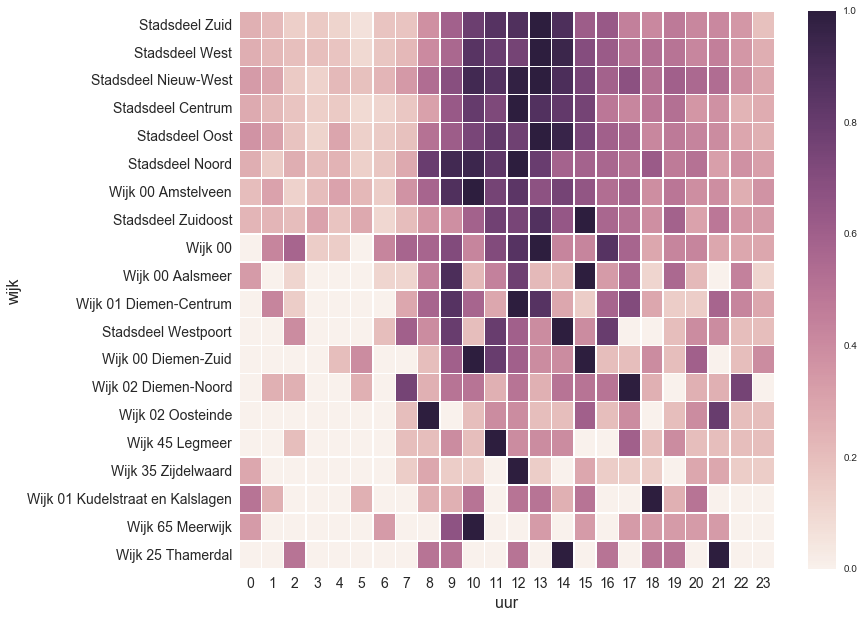

In [12]:
#### heatmap
ax = sns.heatmap(tab_n, linewidths=.5 ,robust=False ,annot_kws = {'size':14})
ax.tick_params(labelsize=14)
ax.figure.set_size_inches((12, 10))  # update the plot size

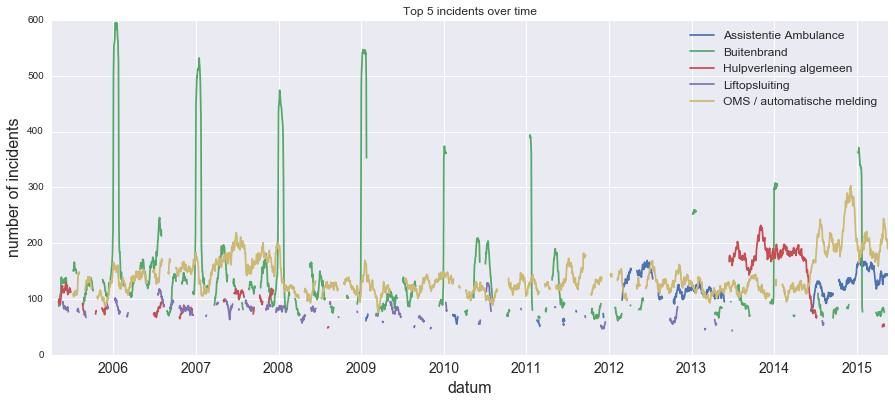

In [13]:
## plot top 5 incidents over time. 
p = (df.query("incident_type != 'Onbekend'").loc[df['incident_type'].isin(df['incident_type'].value_counts().index[:5])]
   .set_index('datum')
   # TimeGrouper to resample & groupby at once
   .groupby(['incident_type', pd.TimeGrouper("H")])
   .buurt.count()
   .unstack(0)
   .rolling(24)
   .sum()
   .plot()
)
_ = p.set(xlabel = 'datum', ylabel ='number of incidents', title = 'Top 5 incidents over time'), p.legend(fontsize = 12.)

We can clearly see how buitenbranden (fires) are spiking at New Year's

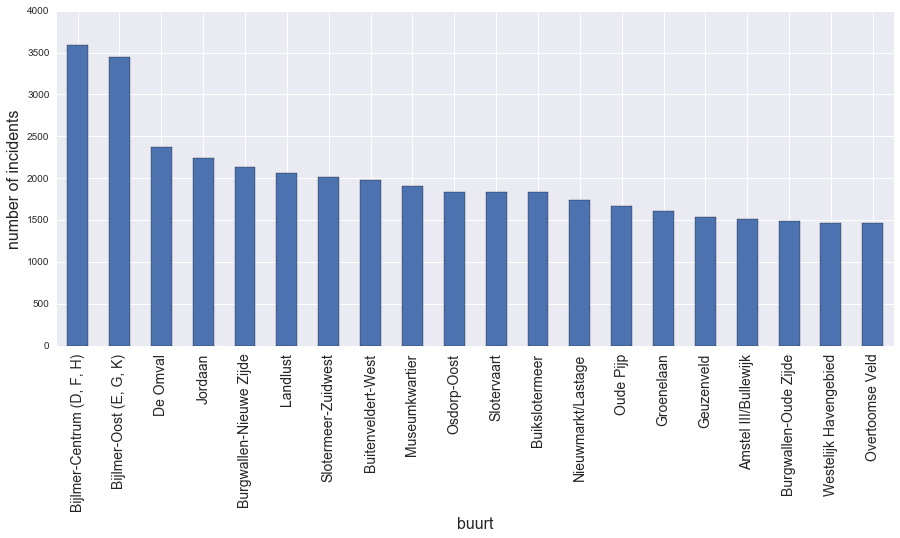

In [17]:
# summed indicents per wijk (neighborhood)
p = df.query("buurt != 'Onbekend'").buurt.value_counts()[:20].plot.bar(rot=90)
_ = p.set(xlabel = 'buurt', ylabel = 'number of incidents')

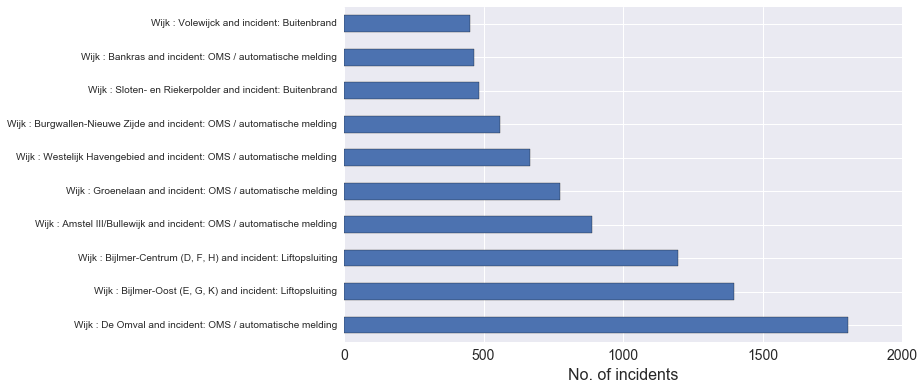

In [16]:
# most common incident per wijk sorted
c = sorted(list(Counter([tuple(x) for x in df.query("buurt != 'Onbekend'")\
                         .dropna(subset = ["buurt", "incident_type"])
                  [["buurt", "incident_type"]].values]).items()), key = lambda x: x[1], reverse= True)
p = pd.DataFrame(c)[:10].plot.barh(figsize = (10, 6))
_ = p.set(yticklabels = ["Wijk : %s and incident: %s" % (x[0], x[1]) for x in list(zip(*c))[0]]
           , xlabel = "No. of incidents"), p.legend("")

Not sure what 'automatische melding' could mean but it's surely happening a lot in the Omval. Liftopsluitingen (person stuck in an elevator) occur a lot in the Bijlmer where lots of appartment blocks are located.

## time to get a high-over view on what incidents occur a lot in which neigborhood

Clustermaps are great for this and the Seaborn has one that isn't hard to construct. Clustermaps are hierarchically clustered heatmaps of a dataframe

In [19]:
# first get the rightly formatted data in for the clustermap
def incident_wijk(df,per):
    
    # Group by incident_type and wijk 
    t =(df.groupby('incident_type')['wijk'].value_counts(sort=True).unstack().fillna(0))
           
    # Sort by wijk_sum
    wijk_sum = t.sum(axis=0).sort_values(ascending=False)
    t=t[wijk_sum.index]
    
    # Filter by incident_sum per wijk
    incident_sum=t.sum(axis=1).sort_values()    
    
    # slice data.
    p=np.percentile(incident_sum,per) #Compute  qth percentile of data along specified axis.
    ix=incident_sum[incident_sum>p]
    t=t.loc[ix.index]
    return t
    
t=incident_wijk(df,25)

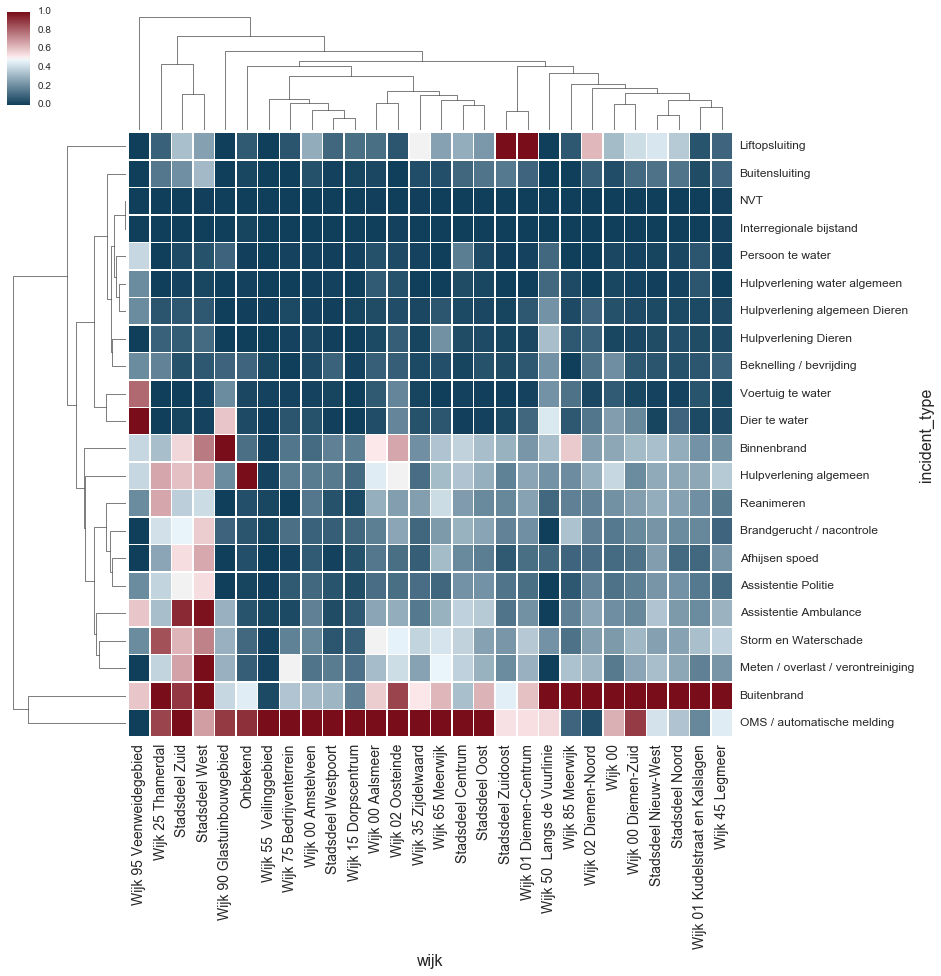

In [22]:
# construct a nice colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=10, s=90, l=25, as_cmap=True) 
# Distance metric to use for the data is euclidean 
cg = sns.clustermap(t, metric="euclidean", standard_scale=1, 
                    linewidths=.5, figsize=(13, 13), cmap=cmap)
# Normalize vertically across wijk.
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, size= 12)

The height of the dendogram branches indicate the degree of difference between branches. F.i Wijk 95 Veenwijdegebied (simplicifolious) is very different from the other neighborhoods: here the main incident is clearly the 'dier/voertuig te water'. There is great simmilarity between 'Stadsdeel Zuidoost' and 'Wijk 01 Diemen-Centrum' for having common problems with people that are stuck in elevators. 

Lots of similar neighborhoods can be distinguished: leafs that are most similar, joining together first in the branching diagram like 'Stadsdeel Zuid' and 'Stadsdeel West' or 'Wijk 00 Aalsmeer' and 'Wijk 02 Oosteinde'. The latter is not surprising because Oosteinde is part of Gemeente Aalsmeer but the clustermap shows they are also similar in kinds of incidents.

In [23]:
# create pivot table for plotting purposes
wijken = df.wijk.unique()
wijken_to_skip = ['Onbekend' ,'Wijk 50  Langs de Vuurlinie', 'Wijk 55  Veilinggebied',
                  'Wijk 65 Meerwijk', 'Wijk 75 Bedrijventerrein', 'Wijk 85 Meerwijk',
                  'Wijk 90 Glastuinbouwgebied', 'Wijk 95 Veenweidegebied', 'Wijk 15 Dorpscentrum']
l3 = [x for x in wijken if x not in wijken_to_skip]

by_date = df[(df.jaar >= 2006) & (df.incident_type == 'Buitenbrand') & (df.wijk.isin(l3))]\
            .pivot_table('incident_type' ,index= 'datum', columns='wijk', aggfunc = 'count', )\
            .fillna(0)

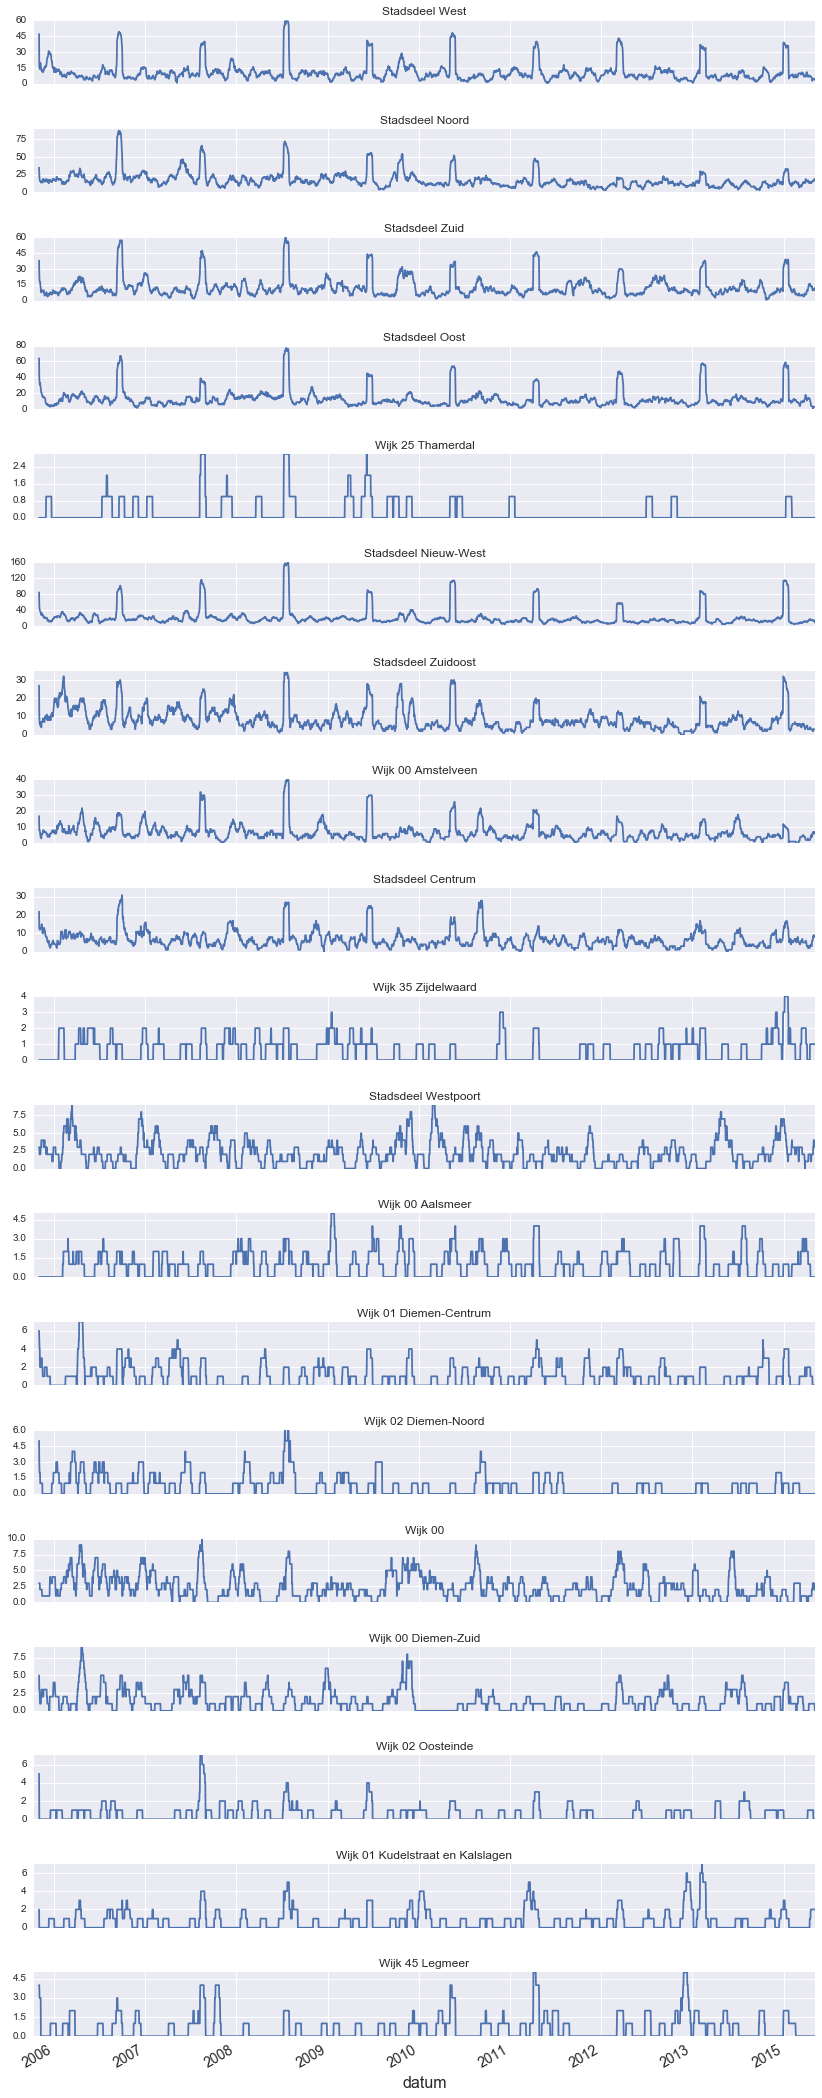

In [24]:
# plot the 'buitenbranden' per wijk over time by looping through. Clear splikes can be seen in the data.
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
fig, ax = plt.subplots(len(by_date.columns), 1, figsize=(14, 40), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0.7)

for i, col in enumerate(l3):
    by_date[col].rolling(24).sum().plot(ax=ax[i], title=col)
    ax[i].xaxis.set_ticks(np.arange(2006, 2015, 10))
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins = 10))
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins=4))

## Some more explorations with more dynamic plots

Because there are multiple ways to look at the data let's define a function where we can dynamically throw in a year and a variable to count on to display in horizontal barchart. Now we can quickly see rankings of different types and year.

In [25]:
df.head(1)

,incident_id,start_tijd,incident_type,melding_1,melding_2,melding_3,datum,jaar,maand_nr,maand_naam,dag_nr,dag_naam,week_nr,kwartaal,prioriteit,uur,dagdeel,objecttype,objectfunctie,buurt,wijk,woonplaats,gemeente,index
0,84149,2009-12-07 20:01:50,Meten / overlast / verontreiniging,Dienstverlening,Burger Dienst,Stankoverlast Burger,2009-12-07,2009,12,December,7,Dinsdag,50,4,2,20,Avond,bag,Woonfunctie,Kinkerbuurt,Stadsdeel West,Amsterdam,Amsterdam,1


In [25]:
def flex_barchart(df, jaar, group_field, length, width):
    df_year = df[df.jaar == jaar]
    grouped = (df_year.groupby(group_field, as_index=False)
                      .size()
                      .reset_index()
                      .rename(columns={0: 'count'})
                      .sort_values('count', ascending=False))
    
    fig, ax = plt.subplots(figsize=(width,length))
    sns.barplot(x="count", y=group_field, data=grouped)

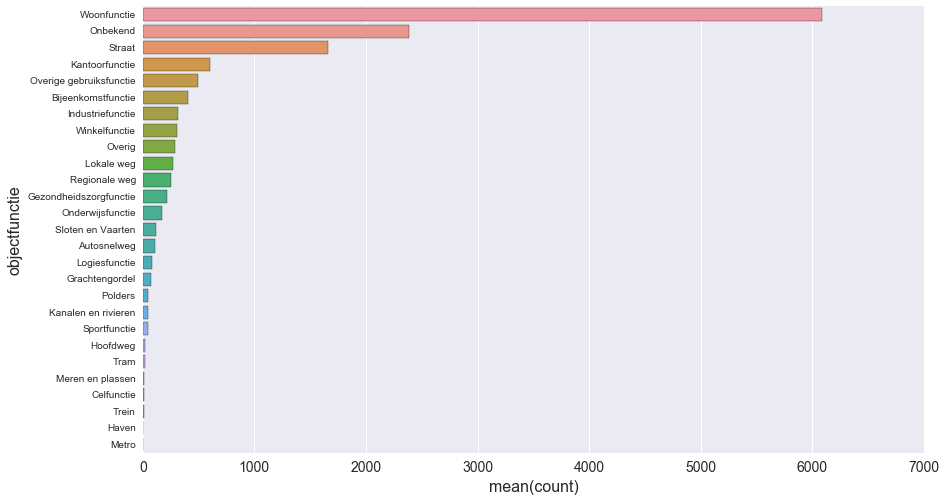

In [26]:
# so play around here: you can choose incident_type, melding_1, melding_2, melding_3 etc..
flex_barchart(df, 2006 , 'objectfunctie', 8, 14)

### Flexible heatmap

Let's make a heatmap a bit more flexible by throwing it into a function as well so we can play around with it using different variables.

In [27]:
def pivot_heatmap(df, jaar, rows, columns, values, width, length):
    df_year = df[df.jaar == jaar]
    df_pivot = df_year.pivot_table(values=values, index=rows, columns=columns, 
                                   aggfunc=np.size).dropna(axis=0, how='all')
    
    fig, ax = plt.subplots(figsize=(width,length))
    sns.heatmap(df_pivot, annot=False, fmt='g')

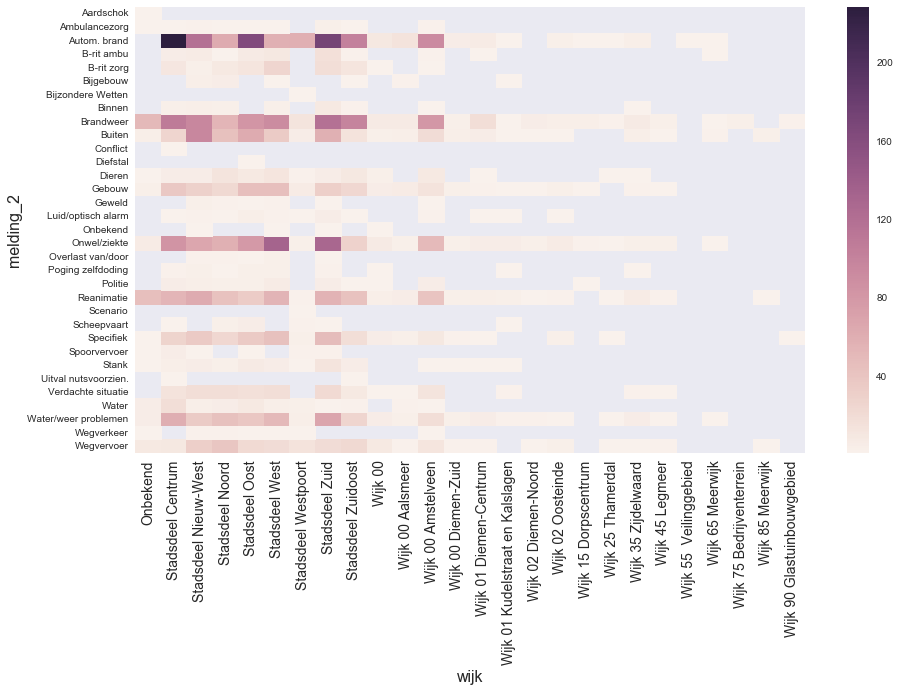

In [28]:
pivot_heatmap(df, 2015, 'melding_2','wijk','index', 15, 8)

### Look at hourly patterns

In [29]:
# create pivot table with hourly patterns for plotting purposes
df['weekend'] = np.where(df.dag_naam.isin(['Zaterdag' ,'Zondag']), 'weekend', 'weekdag')
hourly = (df.query("incident_type == 'Buitenbrand' | incident_type == 'OMS / automatische melding' \
                   | incident_type == 'Liftopsluiting'")
            .pivot_table('index', aggfunc='count', index=['weekend','uur'], columns=['incident_type']))

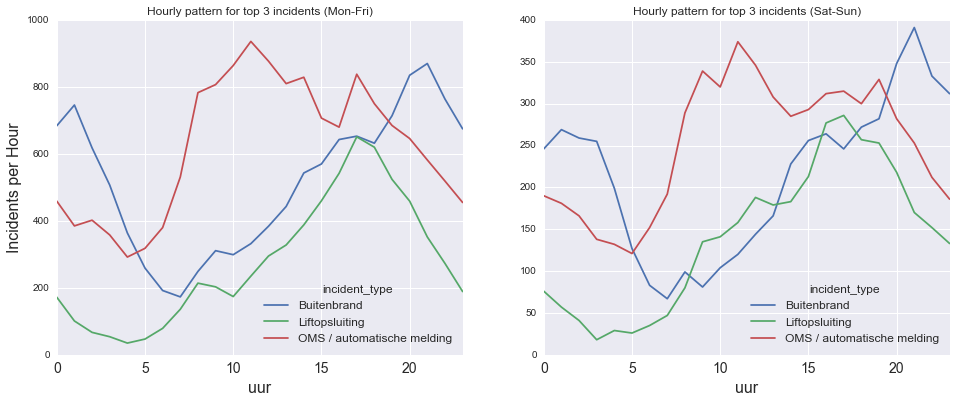

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
hourly.loc['weekdag'].plot(title='Hourly pattern for top 3 incidents (Mon-Fri)', ax=ax[0])
hourly.loc['weekend'].plot(title='Hourly pattern for top 3 incidents (Sat-Sun)', ax=ax[1])
ax[0].set_ylabel('Incidents per Hour');

OMS/automatische meldingen spike at 11h in both weekdays and weekends. Actually we see similar hourly patterns for the top 3 incidents for weekdays and weekends in general. Quit surprising considering the out-going scene in the weekends. Buitenbranden (fires) don't occur much in the very early morning hours but gradually mount until the spike at +/- 21/22h.

### Create dynamic line plotting

In [31]:
def multi_line(df, x, y):
    ax = df.groupby([x, y]).size().unstack(y).plot(figsize=(15,8), cmap="Set2")

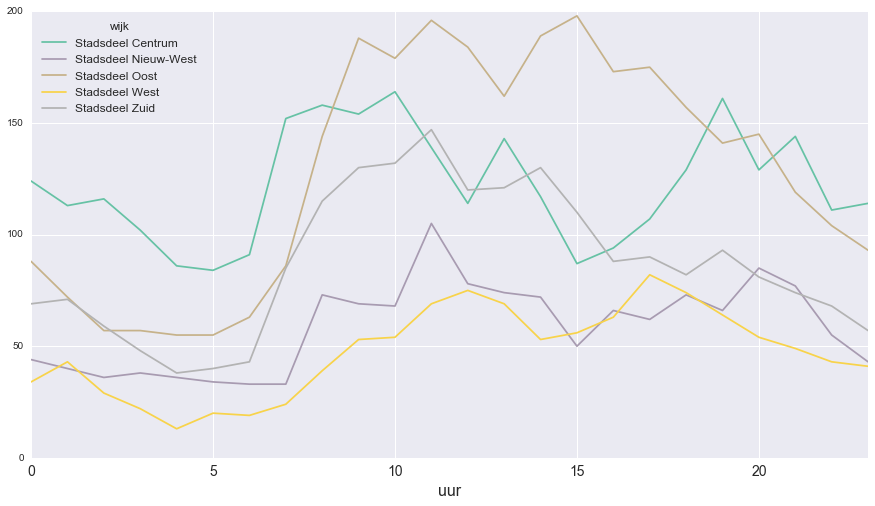

In [32]:
# plot the number of incidents per hour for the top x neigborhoods
multi_line(df.loc[df['incident_type'].isin(df['incident_type'].value_counts().index[:1])]\
             .loc[df['wijk'].isin(df['wijk'].value_counts().index[:5])], 'uur', 'wijk')

hourly patterns can differ significantly per wijk

### Last plot with more grids/panels

In [34]:
incidents = ['OMS / automatische melding', 'Buitenbrand', 'Liftopsluiting', 'Buitensluiting']
dummies = pd.get_dummies(df['incident_type'])
data = pd.concat([df, dummies], axis=1)

In [35]:
## Some more custom plotting code
def plot_incidents_by_time(data, unit='uur', wijk =None, panel=None, agg_func='count'):
    ''' Custom plotting functions that displays the number of
    incidents of each type as a function of a unit of time and
    (optionally) any categorical variable.
    '''
    if wijk is not None:
        data = data[data['wijk'].isin(wijk)]
    if panel is not None:
        if panel == 'jaar':
            panel_vars = [2010, 2011, 2012, 2013, 2014]
        else:
            panel_vars = sorted(data[panel].unique())
        n_panels = len(panel_vars)
        fig, axes = plt.subplots(1, n_panels, figsize=(20, 8), sharex=True, sharey=True)
        fmt = plt.FuncFormatter(lambda x, *args: '{0}:00'.format(int(x)))
    else:
        axes = [plt.gca()]

    incidents = ['OMS / automatische melding', 'Buitenbrand', 'Liftopsluiting', 'Buitensluiting']
    dummies = pd.get_dummies(data['incident_type'])
    data = pd.concat([data, dummies], axis=1)
    
    
    for oc in incidents:
        groupers = [unit]
        if panel is not None:
            groupers.append(panel)
        line = data.query('incident_type==@oc')\
            .groupby(groupers)[oc].agg(agg_func).reset_index()
        if panel is not None:
            for i, pan in enumerate(panel_vars):
                pan_line = line[line[panel]==pan]
                axes[i].plot(pan_line[unit], pan_line[oc], label=oc, lw=3)
                axes[i].set_title('{}: {}'.format(panel, pan), fontsize=12)
                if unit == 'uur':
                    axes[i].xaxis.set_major_formatter(fmt)
                    axes[i].xaxis.set_major_locator(plt.MultipleLocator(8))
                elif unit == 'week_nr':
                    axes[i].xaxis.set_major_locator(plt.MultipleLocator(12))
                else:
                    axes[i].xaxis.set_major_locator(plt.MultipleLocator(2))
                    
    plt.legend(fontsize=10, loc='upper left')
    plt.suptitle('Trends: {} per {}'.format(unit, panel), size=16);

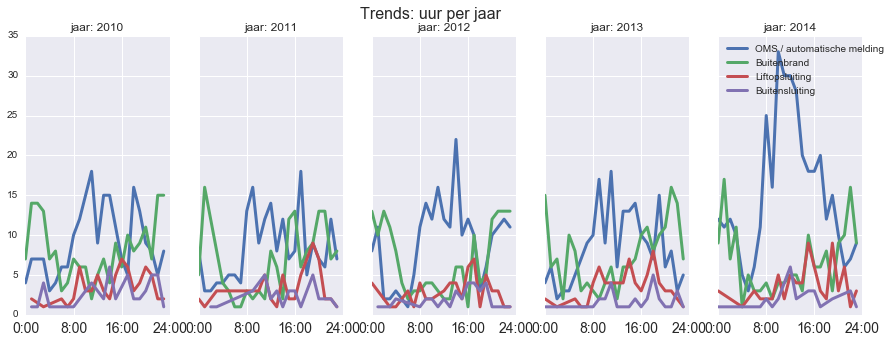

In [36]:
# unit (what will be depicted on ind. x-axis) =  choose between uur/ week_nr or maand_nr
# panel (what will be depicted in each panel)
plot_incidents_by_time(df, wijk=['Stadsdeel Zuid'], unit='uur', panel='jaar')
plt.gcf().set_size_inches((15, 5))

### Adding 

To be honest the dataset has not much to offer in terms quantative fields. What if we could add a huge amount of statistics per Amsterdam district and attach it to the data ??

De Wijk- en buurtkaart (jaar 2003 -) contains the digital geometry of the borders of all neighborhoods and municipalities in an ESRI™-shape format. What is cool is that a lot of statistics have been added to the maps that we can add back to our dataframe. All of a sudden we have so much more info about our neighboorhoods.

You can download them here: 
https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data#id=wijk-en-buurtkaart-2016-0

Preliminaries on shapefiles:

- shapefile (.shp) file contains geometric attributes (points, lines, polygons) per Dutch municipality 
- .dbf file contains the attributes of each of your geometries 
- .shx (index files) quickly accessible file of your spatial units/geometries

** pls mention the CBS and Kadaster as your source if you use the data

In [37]:
# Read in the shapefile from your local dir 
wijk = shapefile.Reader('C:\\Users\\Schiphol\\Documents\\data\\esri_poly\\uitvoer_shape\\wijk_2014.shp')

A record in a shapefile contains the attributes for each shape in the collection of geometry. Records are stored in the dbf file. The link between geometry and attributes is the foundation of all geographic information systems. This critical link is implied by the order of shapes and corresponding records in the shp geometry file and the dbf attribute file.

Call the “fields” attribute of the shapefile as a Python list. Every wijk has a ton of underlying info
just watch the rich underlying layers: 
- field name
- field type (C - Charachter, N -Number, L = Longs, D - Dates, M - Memo)
- fields length (length of the data)
- decimal length -  number of decimal places

In [38]:
#glance at the first 10
wijk.fields[:10]

[('DeletionFlag', 'C', 1, 0),
 ['WK_CODE', 'C', 8, 0],
 ['WK_NAAM', 'C', 60, 0],
 ['GM_CODE', 'C', 6, 0],
 ['GM_NAAM', 'C', 60, 0],
 ['IND_WBI', 'N', 10, 0],
 ['WATER', 'C', 4, 0],
 ['OAD', 'N', 10, 0],
 ['STED', 'N', 10, 0],
 ['AANT_INW', 'N', 10, 0]]

The list is very long. If you are curious check the link to explanations what each fieldname means: https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische%20data/wijk-en-buurtkaart-2015

In [48]:
shape_file = "C:\\Users\\Schiphol\\Documents\\data\\esri_poly\\uitvoer_shape\\wijk_2014.shp"

In [42]:
def records_from_shapefile(filename):  
    """
    Input: shapefile
    Function to extract the field names + records for the neighborhoods
    of Amsterdam from the shapefile 
    Output: list with tuples
    """
    reader = shapefile.Reader(filename)  
    # first field, called "DeletionFlag", is just trash (thus the [1:])
    field_names = [field_name for field_name, _, _, _ in reader.fields[1:]]
    
    results = []
    for rec in reader.records():
        if rec[3] == 'Amsterdam':  # rec[3] = 'GM_NAAM'
            results.append(list(zip(field_names, rec)))
            
    return results

In [52]:
shapefile_stats = records_from_shapefile(shape_file)

In [53]:
# Glance at first 10 elements of first list
shapefile_stats[0][:10]

[('WK_CODE', 'WK036300'),
 ('WK_NAAM', 'Stadsdeel Centrum'),
 ('GM_CODE', 'GM0363'),
 ('GM_NAAM', 'Amsterdam'),
 ('IND_WBI', 1),
 ('WATER', 'NEE'),
 ('OAD', 8995),
 ('STED', 1),
 ('AANT_INW', 86010),
 ('AANT_MAN', 44440)]

In [54]:
# zip function to decouple the fieldnames from the values
columns = list(zip(*shapefile_stats[0]))[0]

In [59]:
# loop through the items in the list, loop through key values from these items. Create pd dataframe
record_dict = {}
for items in shapefile_stats:
    for k, v in items:
        record_dict.setdefault(k, []).append(v)

shape_df = pd.DataFrame.from_dict(record_dict).set_index(['WK_NAAM']).iloc[:-1:]

In [58]:
# we now have 193 stats per Amsterdam district, ready to be used and joined to our data ;-
shape_df

,AANTAL_HH,AANT_INK,AANT_INW,AANT_MAN,AANT_VROUW,AF_APOTH,AF_ARTSPR,AF_ATTRAC,AF_BIBLIO,AF_BIOS,AF_BRANDW,AF_BSO,AF_CAFE,AF_CAFTAR,AF_DAGLMD,AF_HOTEL,AF_IJSBAAN,AF_KDV,AF_ONDBAS,AF_ONDHV,AF_ONDVMB,AF_ONDVRT,AF_OPRITH,AF_OVERST,AF_PODIUM,AF_POP,AF_RESTAU,AF_SAUNA,AF_SUPERM,AF_TREINST,AF_WARENH,AF_ZIEK_E,AF_ZIEK_I,AF_ZONBNK,AF_ZWEMB,AO_UIT_TOT,AUTO_HH,AUTO_LAND,AUTO_TOT,AV10ATTRAC,AV10ONDVMB,AV10ONDVRT,AV10PODIUM,AV10WARENH,AV10ZIEK_E,AV10ZIEK_I,AV10_BIOS,AV10_HOTEL,AV10_ONDHV,AV1_ARTSPR,...,INK_ONTV,MOTOR_2W,OAD,OPP_LAND,OPP_TOT,OPP_WATER,P_00_14_JR,P_15_24_JR,P_1GEZW,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_ACTIEF,P_ANT_ARU,P_EENP_HH,P_GEBOO,P_GEHUWD,P_GESCHEID,P_HH_M_K,P_HH_Z_K,P_HOOGINKH,P_HOOGINKP,P_HUKO_ONB,P_HUURWON,P_KOOPWON,P_LAAGINKH,P_LAAGINKP,P_LIK_HH,P_MAROKKO,P_MGEZW,P_N_W_AL,P_ONGEHUWD,P_OVER_NW,P_SOCMINH,P_STADVERW,P_STERFT,P_SURINAM,P_TURKIJE,P_VERWEDUW,P_WEST_AL,P_WONT2000,P_WONV2000,STED,STERFT_TOT,WATER,WK_CODE,WONINGEN,WOZ,WWB_UITTOT,WW_UIT_TOT
WK_NAAM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Stadsdeel Centrum,55420,70000,86010,44440,41570,0.5,0.4,1.9,1.3,0.9,1.1,0.4,0.2,0.2,0.2,0.3,5.1,0.3,0.5,1.2,1.9,1.1,3.6,1.7,0.6,1.9,0.1,1.2,0.3,1.5,0.9,1.6,1.6,0.7,1.4,3120,0.4,3143,19735,4.0,41.6,64.8,46.9,28.0,7.1,8.1,13.3,370.6,34.2,6.9,...,37.4,2330,8995,628,804,176,10,12,5,37,28,13,62,1,65,10,21,9,14,21,19,29,1,71,28,53,39,18,2,95,15,68,8,15,-99999999,7,3,1,2,24,93,7,1,610,NEE,WK036300,53800,309,2830,2300
Stadsdeel Westpoort,290,200,420,300,120,3.7,3.6,9.5,3.7,6.0,4.7,3.1,2.8,1.6,2.9,2.9,12.6,3.1,3.2,4.1,4.2,3.9,2.0,3.9,5.0,7.9,2.4,4.4,3.4,3.7,4.1,5.5,5.5,4.0,4.8,20,-99999999.0,-99999999,3305,1.5,23.8,38.3,25.5,16.1,4.3,4.3,8.9,209.4,19.6,0.0,...,20.4,125,746,2605,3528,924,4,9,51,43,39,6,64,0,83,14,17,9,8,9,6,10,5,85,10,76,62,48,3,49,16,73,7,41,0,2,5,1,1,37,72,28,4,0,NEE,WK036301,108,202,30,10
Stadsdeel West,82985,112400,140960,69735,71225,0.4,0.3,4.3,0.7,1.3,1.5,0.3,0.2,0.2,0.2,0.6,7.7,0.3,0.3,1.3,1.1,0.8,1.6,2.7,0.8,2.5,0.2,1.6,0.3,2.4,1.2,2.0,2.0,0.7,1.3,6250,0.4,3379,29490,3.4,39.4,63.2,46.0,29.0,7.3,7.7,13.4,373.2,33.8,7.0,...,29.5,3115,9141,873,990,117,14,12,1,43,22,8,61,1,60,16,20,8,20,20,13,22,1,74,25,57,42,20,10,99,31,69,9,17,-99999999,4,5,6,2,17,94,6,1,700,NEE,WK036302,76489,211,8350,4260
Stadsdeel Nieuw-West,67335,104800,143975,71355,72615,0.7,0.6,7.8,1.3,5.0,2.0,0.5,0.6,0.4,0.4,1.2,10.9,0.4,0.5,1.5,1.3,1.1,1.7,4.4,2.1,5.8,0.4,1.6,0.6,2.5,1.7,2.3,2.3,1.1,2.5,7380,0.6,1484,43105,2.4,31.2,51.0,40.6,22.3,5.8,5.8,11.9,363.2,30.0,3.0,...,26.3,2640,3562,2905,3253,348,18,15,25,30,24,13,53,1,46,14,33,9,33,21,15,17,1,72,27,51,45,18,21,75,51,55,10,14,9,7,7,13,4,12,82,18,1,1025,NEE,WK036303,62749,181,8060,3620
Stadsdeel Zuid,82725,111700,139490,66150,73340,0.4,0.4,3.3,1.0,1.9,1.7,0.4,0.4,0.2,0.2,0.5,5.3,0.3,0.4,0.7,0.7,0.6,1.6,2.6,1.0,2.5,0.2,1.7,0.3,1.8,1.0,1.9,1.9,0.6,1.9,5020,0.5,2752,42885,4.2,42.3,65.8,47.8,26.8,8.4,9.0,12.9,373.8,36.2,6.5,...,39.8,2905,7229,1559,1741,183,13,11,4,38,23,15,62,1,59,14,24,9,20,22,21,30,0,72,27,49,36,14,3,96,17,64,8,13,-99999999,7,3,2,4,22,96,4,1,1010,NEE,WK036304,77723,308,4530,3380
Stadsdeel Oost,66295,95100,126140,62500,63640,0.6,0.4,3.3,1.7,2.2,2.1,0.4,0.9,0.3,0.4,1.6,3.2,0.4,0.4,1.5,1.3,1.0,2.6,4.3,2.2,4.8,0.3,2.3,0.5,2.1,1.5,2.7,1.7,1.0,2.5,5660,0.5,1733,30805,4.2,37.8,58.7,43.0,25.0,6.5,7.7,12.4,352.8,31.2,5.9,...,32.2,2860,5514,1777,2252,475,18,13,8,36,24,9,60,1,53,14,24,8,27,20,19,25,0,72,27,50,40,18,10,92,33,66,9,14,20,4,8,5,2,15,74,26,1,595,NEE,WK036305,62980,234,6230,3350
Stadsdeel Noord,42895,67100,89900,43660,46240,0.8,0.7,6.1,1.1,5.2,2.1,0.7,0.9,0.6,0.6,1.7,9.0,0.6,0.5,2.4,1.4,1.4,2.0,5.9,2.6,2.6,0.6,5.4,0.8,5.8,1.9,3.0,3.0,2.4,2.5,5250,0.7,675,28430,2.3,27.1,46.3,38.6,22.1,4.1,4.8,12.6,345.1,22.6,2.0,...,25.2,2445,2363,4214,4898,685,18,12,33,28,26,16,53,1,45,12,31,10,34,22,12,14,0,74,26,53,45,18,10,67,38,54,12,15,-99999999,8,8,6,5,10,91,9,2,780,NEE,WK036306,41425,175,5560,2520
Stadsdeel Zuidoost,42835,62400,8403

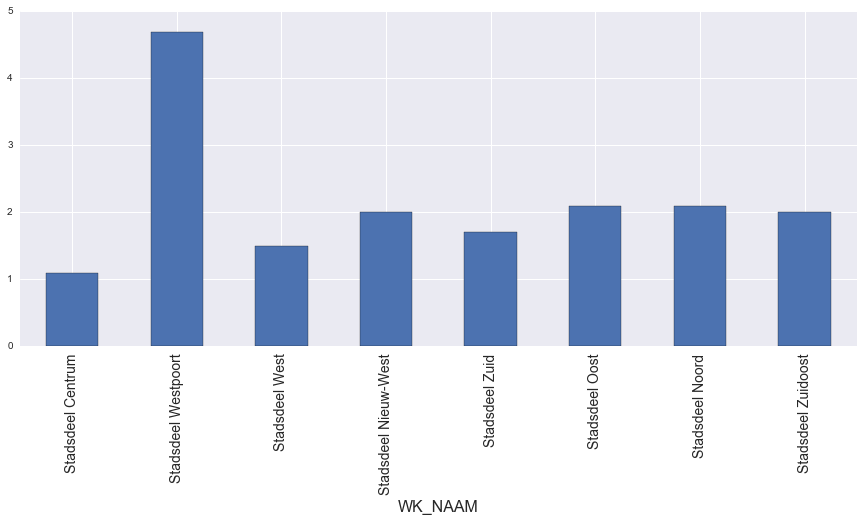

In [47]:
# one stat is nice for this analysis: AF_BRANDW which is the av distance from a firefighter center:
shape_df['AF_BRANDW'].plot.bar()

In [60]:
# It's now easy to join whatever statistic to the df. Let's pick some 
select_cols = ['AANT_INK', 'P_SOCMINH', 'AF_BRANDW', 'INK_INW']
(df.query("incident_type == 'Buitenbrand' & jaar == 2014")
    .groupby(['wijk']).size().to_frame('fires')
    .join(shape_df[select_cols], how='inner')
)

,fires,AANT_INK,P_SOCMINH,AF_BRANDW,INK_INW
Stadsdeel Centrum,72,70000,15,1.1,32.1
Stadsdeel Westpoort,39,200,41,4.7,18.3
Stadsdeel West,133,112400,17,1.5,24.2
Stadsdeel Nieuw-West,252,104800,14,2.0,19.8
Stadsdeel Zuid,160,111700,13,1.7,32.7
Stadsdeel Oost,182,95100,14,2.1,25.0
Stadsdeel Noord,162,67100,15,2.1,19.2
Stadsdeel Zuidoost,108,62400,19,2.0,18.4


# Plot the district polygons from the shapefile

There is off course more to the Shapefile then extracting the stats. The Polygons can be used to plot on maps. There are handy modules for this but let's first stick to more rawer Python.

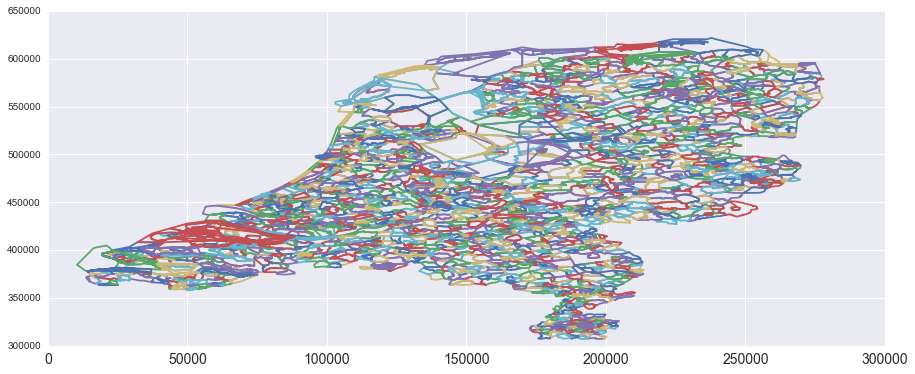

In [14]:
# let's plot the full shapefile with Matplotlib
plt.figure()
for shape in wijk.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

Unreadible and too much info. Let's only plot Amsterdam neighborhoods

In [62]:
def read_shapefile_plot(filepath):
    """
    Read shapefile at filepath with the pyshp library
    returns plot based on filtered records (Amsterdam districts in this case)
    """
    reader = shapefile.Reader(filepath)
     
    for rec, shape in zip(reader.iterRecords(), reader.iterShapes()):
        if (rec[3] == 'Amsterdam'):
            x = [i[0] for i in shape.points[:]]
            y = [i[1] for i in shape.points[:]]
            plt.plot(x,y)

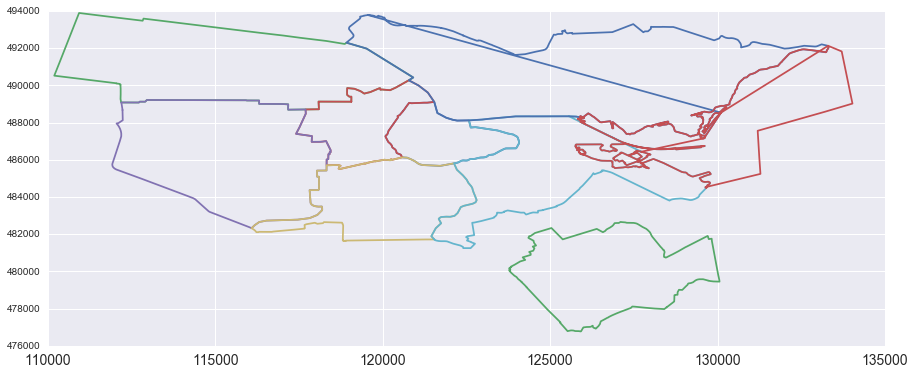

In [63]:
read_shapefile_plot(shape_file)

hmm The contours of Amsterdam are now visible but the plot is ugly.

There are neat ways to plot Polygons on maps. I recommend **Shapely** for manipulation and analysis of geometric objects and **Fiona**, a simple module that can read and write data using multi-layered GIS formats. It's neat. 

Installing it can be somewhat tricky as it depends on GDAL (Geospatial Data Abstraction Library). If you are using windows, best is probably to download the packages from  http://www.lfd.uci.edu/~gohlke/pythonlibs/. This is a page providing 32- and 64-bit Windows binaries of many extension packages for the official CPython distribution of the Python programming language. You can then Pip install the exact version of your dowloaded package from the command line (like Anaconda prompt). F.i. **pip install Shapely‑1.5.17‑cp35‑cp35m‑win_amd64.whl** (executed from the folder where your downloaded file landed). You should do the same for **fiona, gdal and geopandas** that we'll use here.

If your 'wheel' (.whl) is not there and you are using Windows, you might need to install a compiler toolset. Check this excellent blog post if you are running into trouble: https://blogs.msdn.microsoft.com/pythonengineering/2016/04/11/unable-to-find-vcvarsall-bat/

### Plot the Polygons of the Amsterdam districts with Shapely

In [64]:
# let's peek into the first shapefile record with fiona
import pprint
import fiona
with fiona.open(shape_file, 'r') as src:
    pprint.pprint(src[1])
    
# note that I use the 'pprint' module. It provides a capability to “pretty-print” arbitrary 
# Python data structures in a form which can be used as input to the interpreter.

{'geometry': {'coordinates': [[(235109.7338284999, 586121.0819357),
                               (235105.78302850202, 586121.8170357011),
                               (235097.63002850115, 586123.3350357004),
                               (235089.09302850068, 586124.464035701),
                               (235072.61702850088, 586132.9580357),
                               (235071.08172849938, 586133.9171357006),
                               (235061.20802849904, 586140.0860357024),
                               (235060.2350285016, 586138.8480357006),
                               (235056.62902849913, 586139.4570357017),
                               (235026.45202850178, 586142.9930357002),
                               (235026.66702850163, 586143.6670357026),
                               (235027.476028502, 586146.209035702),
                               (235039.0310285017, 586198.2230357006),
                               (235046.06702850014, 586251.702035699),
      

In [137]:
from shapely.geometry import Polygon, MultiPolygon, shape, Point
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

ams_polygon = MultiPolygon(
[shape(pol['geometry']) for pol in fiona.open(shape_file) 
 if pol['properties']['GM_NAAM'] == 'Amsterdam' or pol['properties']['GM_NAAM'] == 'Amstelveen'])

# ams_polygon is a 'shapely.geometry.multipolygon.MultiPolygon' class. 

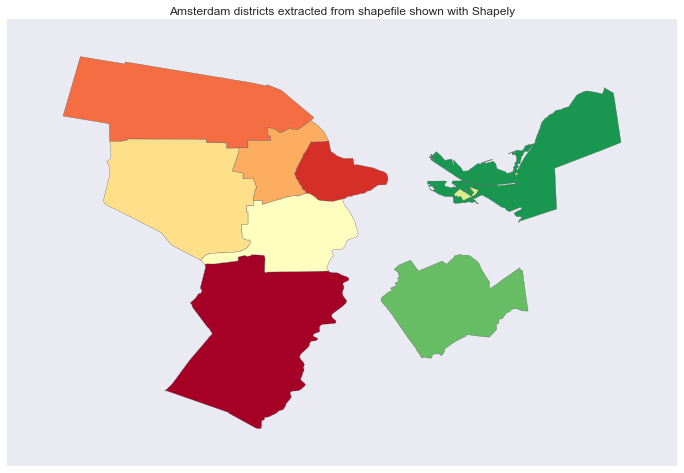

In [66]:
fig, ax = plt.subplots(figsize=[12,8])

cm = plt.get_cmap('RdYlGn') # my favorite 'Diverging' matplotlib colormap
no_cols = len(ams_polygon) # 10 districts including Amstelveen
 
minx, miny, maxx, maxy = ams_polygon.bounds # extracted the map boundaries
width, height = maxx - minx, maxy - miny

patches = []
for idx, i in enumerate(ams_polygon):
    colour = cm(1. * idx / no_cols)
    patches.append(PolygonPatch(i, fc=colour, ec='#555555', alpha=1., zorder=1))
    # PolygonPatch -> Constructs a matplotlib patch from a geometric object
    
ax.add_collection(PatchCollection(patches, match_original=True))
ax.set(xlim = (minx - 0.1 * width,  maxx + 0.1 * width), 
       ylim = (miny - 0.1 * height, maxy + 0.1 * height), 
       xticks = [], yticks= [] ,
       title = 'Amsterdam districts extracted from shapefile shown with Shapely');

Much better although we see that some districts are missing. Let's now map the colors to the actual values of fire incidents per district and impose our color map onto the patch collection. For that we will use the excellent geopandas module. http://brandonrose.org/pythonmap.
http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.WL3RdVXhCUm

### GeoPandas

As mentioned above there is a much easier way to join the shapefile stats to the incident dataframe from earlier on with geopandas. 

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. 

In [68]:
# https://gist.github.com/urschrei/92581269922db5b2e0e3
import geopandas as gp

In [69]:
df_ams = gp.GeoDataFrame.from_file(shape_file)

In [72]:
print ('Shape of the geopandas df: {}'.format(df_ams.shape))
df_ams.head()

Shape of the geopandas df: (2836, 185)


,AANTAL_HH,AANT_INK,AANT_INW,AANT_MAN,AANT_VROUW,AF_APOTH,AF_ARTSPR,AF_ATTRAC,AF_BIBLIO,AF_BIOS,AF_BRANDW,AF_BSO,AF_CAFE,AF_CAFTAR,AF_DAGLMD,AF_HOTEL,AF_IJSBAAN,AF_KDV,AF_ONDBAS,AF_ONDHV,AF_ONDVMB,AF_ONDVRT,AF_OPRITH,AF_OVERST,AF_PODIUM,AF_POP,AF_RESTAU,AF_SAUNA,AF_SUPERM,AF_TREINST,AF_WARENH,AF_ZIEK_E,AF_ZIEK_I,AF_ZONBNK,AF_ZWEMB,AO_UIT_TOT,AUTO_HH,AUTO_LAND,AUTO_TOT,AV10ATTRAC,AV10ONDVMB,AV10ONDVRT,AV10PODIUM,AV10WARENH,AV10ZIEK_E,AV10ZIEK_I,AV10_BIOS,AV10_HOTEL,AV10_ONDHV,AV1_ARTSPR,...,OAD,OPP_LAND,OPP_TOT,OPP_WATER,P_00_14_JR,P_15_24_JR,P_1GEZW,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_ACTIEF,P_ANT_ARU,P_EENP_HH,P_GEBOO,P_GEHUWD,P_GESCHEID,P_HH_M_K,P_HH_Z_K,P_HOOGINKH,P_HOOGINKP,P_HUKO_ONB,P_HUURWON,P_KOOPWON,P_LAAGINKH,P_LAAGINKP,P_LIK_HH,P_MAROKKO,P_MGEZW,P_N_W_AL,P_ONGEHUWD,P_OVER_NW,P_SOCMINH,P_STADVERW,P_STERFT,P_SURINAM,P_TURKIJE,P_VERWEDUW,P_WEST_AL,P_WONT2000,P_WONV2000,STED,STERFT_TOT,WATER,WK_CODE,WK_NAAM,WONINGEN,WOZ,WWB_UITTOT,WW_UIT_TOT,geometry
0,5525,9300,12065,5845,6215,1.3,1.4,17.0,1.3,23.5,1.3,1.0,1.0,0.7,0.7,1.1,22.3,1.3,0.7,1.6,2.5,1.3,1.0,25.3,5.6,24.6,0.9,21.6,0.9,1.5,1.2,3.9,3.9,22.6,2.3,740,1.0,222,5275,0.0,1.7,3.7,1.0,2.6,1.0,1.0,0.0,8.6,1.0,0.2,...,975,2377,2458,81,15,11,72,22,30,22,54,1,35,8,43,8,32,33,13,14,0,52,48,46,44,11,0,28,5,41,2,8,0,12,1,2,8,8,86,14,4,145,NEE,WK000300,Wijk 00,5840,142,440,390,"POLYGON ((254777.5410284996 596451.7670357004,..."
1,4310,7800,10495,5245,5245,1.3,1.1,7.6,1.4,11.0,1.9,0.9,6.3,1.0,0.9,1.6,8.0,1.0,0.7,7.5,7.4,7.4,0.9,11.4,9.6,9.6,0.7,10.9,1.1,2.2,1.5,10.4,10.4,9.3,1.9,590,1.1,108,4815,1.1,5.9,9.2,1.6,3.9,0.3,0.3,0.4,7.0,5.7,0.6,...,624,4454,4496,41,17,12,86,21,31,19,59,0,28,10,46,5,38,34,19,17,0,32,67,35,40,7,0,14,2,44,2,5,0,7,0,0,5,4,89,11,4,80,NEE,WK000500,Wijk 00,4500,176,150,260,"POLYGON ((235109.7338284999 586121.0819357, 23..."
2,1830,3100,3980,1980,2000,1.9,1.9,21.5,2.7,22.7,3.1,2.0,1.5,2.7,1.1,2.7,46.1,4.6,1.0,11.4,2.7,2.7,1.9,44.5,12.0,47.5,1.7,10.9,2.4,10.1,11.3,12.1,12.1,11.5,9.8,300,1.3,55,2360,0.0,1.4,1.4,0.0,0.1,0.0,0.0,0.0,3.2,0.2,0.3,...,123,4295,4364,69,14,9,94,20,33,23,51,0,30,8,47,8,31,39,13,14,2,27,72,44,44,11,0,6,2,38,1,8,0,12,0,0,7,9,93,7,5,45,NEE,WK000700,Wijk 00 Bellingwolde,1895,155,110,120,"POLYGON ((275343.5000285022 571102.8750356995,..."
3,430,800,955,505,450,4.1,4.1,17.9,4.5,18.9,4.5,3.8,2.2,3.6,2.9,4.8,47.6,4.2,2.4,9.8,6.2,6.2,2.6,40.3,14.1,45.6,3.9,16.1,4.1,13.2,13.0,14.2,14.2,13.7,5.6,90,1.3,24,575,0.0,1.6,1.6,0.0,0.0,0.0,0.0,0.0,3.8,0.6,0.0,...,51,2411,2450,39,12,9,100,17,40,22,49,0,27,3,54,8,27,47,16,15,2,15,83,44,45,11,0,0,1,34,0,8,0,8,1,0,5,8,93,7,5,5,NEE,WK000701,Wijk 01 Oost,452,178,20,30,"POLYGON ((274502.4062285013 568475.5000356995,..."
4,1735,3100,3980,1965,2015,1.0,1.0,16.5,2.1,17.5,4.9,4.6,0.8,4.7,0.8,6.2,41.4,1.8,0.9,6.1,5.2,5.2,0.8,40.4,7.4,42.6,0.8,14.5,0.9,6.6,6.0,7.5,7.5,6.9,5.5,230,1.3,54,2220,0.0,5.4,6.1,0.8,1.9,0.8,0.8,0.0,4.2,2.4,0.7,...,212,4130,4194,64,13,10,91,17,33,26,52,0,28,8,50,7,32,39,17,15,1,29,70,40,45,9,0,9,2,35,1,7,0,13,0,0,9,7,95,5,5,55,NEE,WK000702,Wijk 02 Blijham,1789,162,100,100,"POLYGON ((268262.6020285003 565419.3001357019,..."


In [133]:
# Let's inner join the fire incidents onto the geopandas dataframe based on Amsterdam districts
fires = (df.query("incident_type == 'Buitenbrand' & jaar == 2014 & wijk != 'Wijk 00'")
    .groupby(['wijk']).size().to_frame('fires'))

df_ams_fires= df_ams.set_index('WK_NAAM').join(fires, how='inner')

Ok so to plot this GeoDataFrame with whatever column value we now have to our disposal we can simply plot the df. A little trick is that if you want to apply 'Choropleth classification schemes' (so that the polygons colorschemes match nicely to the values), you need the **pysal** module (Python Spatial Analysis Library). Pysal allows you to use the 'scheme' plotting parameter of the geo dataframe allowing for choropleth mapping with quantiles. See:

C:\Users\Schiphol\Anaconda3\lib\site-packages\geopandas-0.2.1-py3.5.egg\geopandas\geodataframe.py:447: UserWarning: Invalid k: 10 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


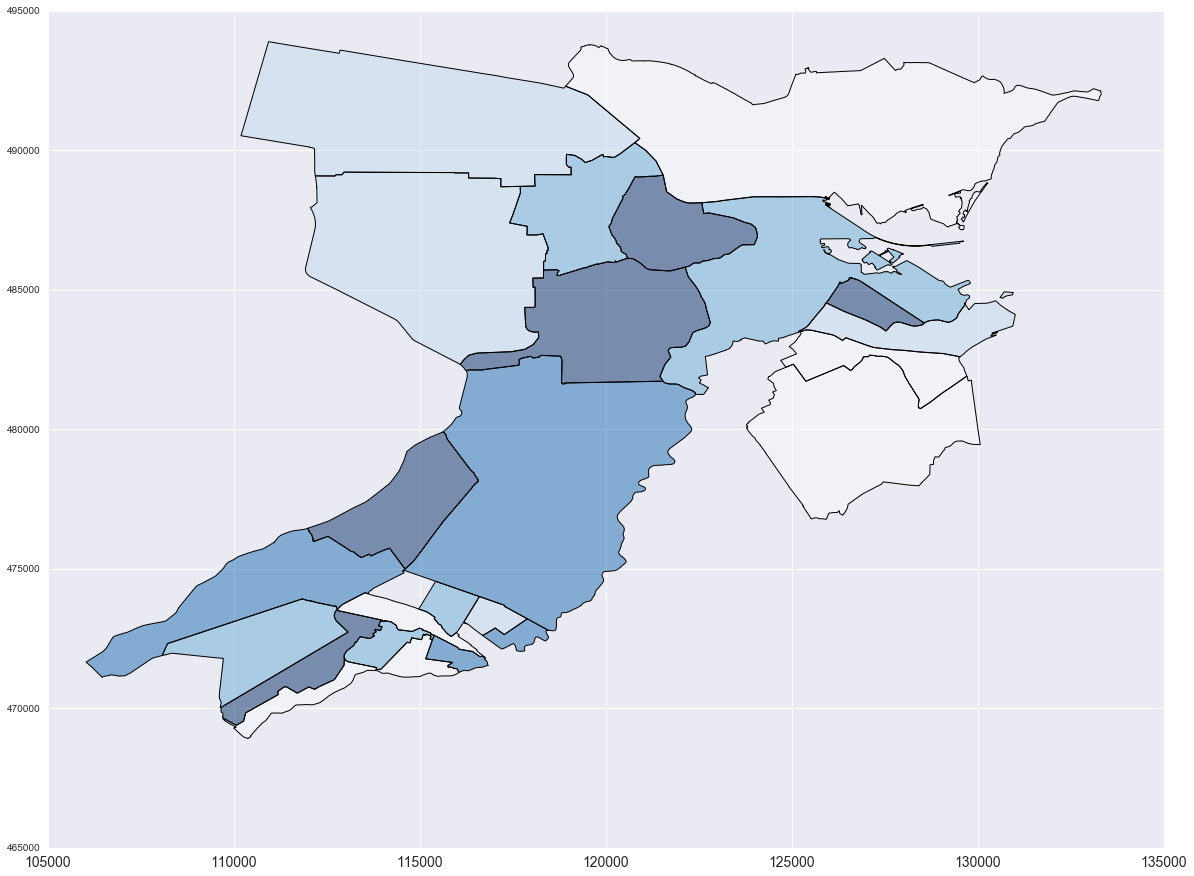

In [189]:
import pysal as ps
fig, ax = plt.subplots(figsize=(20, 15), dpi=100)

# choose whatever column you want 
df_ams_fires.plot(column='WOZ', scheme='Quantiles', k=10, cmap='Blues', ax=ax)

C:\Users\Schiphol\Anaconda3\lib\site-packages\geopandas-0.2.1-py3.5.egg\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


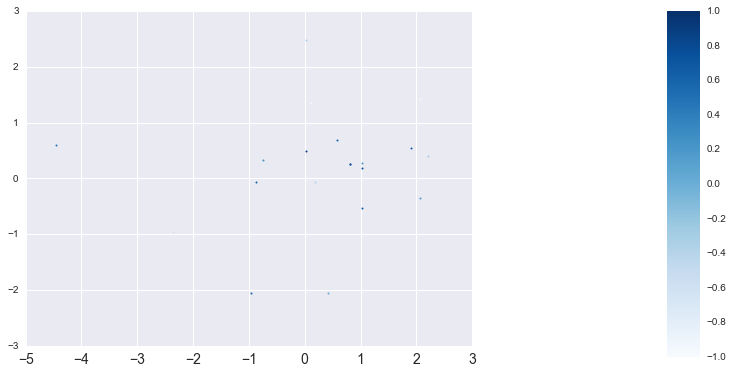

In [142]:
## make up some random data
df = pd.DataFrame(np.random.randn(20,3), columns=['x', 'y', 'val'])
df['geometry'] = df.apply(lambda row: Point(row.x, row.y), axis=1)
gdf = gp.GeoDataFrame(df)

## the plotting

vmin, vmax = -1, 1

ax = gdf.plot(column='val', colormap='Blues', vmin=vmin, vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)